In [1]:
from tree_detection_framework.detection.detector import Detector, DeepForestDetector, Detectree2Detector
from tree_detection_framework.detection.region_detections import RegionDetectionsSet
from tree_detection_framework.detection.models import DeepForestModule, Detectree2Module
from tree_detection_framework.postprocessing.postprocessing import single_region_NMS, multi_region_NMS
from tree_detection_framework.preprocessing.preprocessing import create_dataloader
from tree_detection_framework.preprocessing.preprocessing import (
    create_image_dataloader,
    visualize_dataloader,
    save_dataloader_contents,
)
import torch
import pyproj

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [ ]:
# dataloader = create_dataloader("/ofo-share/repos-amritha/tree-detection-framework/data/emerald-point-ortho", 2000, 1700, batch_size=3)



In [2]:
dataloader = create_image_dataloader(
    "/ofo-share/scratch-amritha/raw_drone_images_for_testing",
    chip_size=2000,
    chip_stride=1800,
    batch_size=3,
)

2025-01-04 00:00:08,261 - INFO - Units set in PIXELS


In [ ]:
visualize_dataloader(dataloader, 2)

In [4]:
# Setup the parameters dictionary use Detectree2
DETECTREE2_MODEL_PARAMS = {
    "update_model": "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"
}

module = Detectree2Module(DETECTREE2_MODEL_PARAMS)
detector = Detectree2Detector(module)

2025-01-04 00:00:13,996 - INFO - [DetectionCheckpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
2025-01-04 00:00:13,997 - INFO - [Checkpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

In [5]:
predictions = detector.predict(dataloader) # return_as_list=True

Performing prediction on batches:   0%|          | 0/3 [00:00<?, ?it/s]/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Performing prediction on batches: 100%|██████████| 3/3 [00:55<00:00, 18.66s/it]


In [3]:
# # Setup the parameters dictionary use DeepForest
# DEEPFOREST_MODEL_PARAMS = {
#     "backbone": "retinanet",
#     "num_classes": 1,
# }

# # The device to use for inference, GPU or CPU
# DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# # This model uses pretrained weights from DeepForest
# module = DeepForestModule(DEEPFOREST_MODEL_PARAMS).to(DEVICE)
# detector = DeepForestDetector(module)

Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.


/ofo-share/repos-amritha/tree-detection-framework/tree_detection_framework/detection/models.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(t

Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [4]:
# predictions = detector.predict(tile_dataloader, return_as_list=True)

Performing prediction on batches: 100%|██████████| 32/32 [06:45<00:00, 12.66s/it]


In [6]:
# predictions_set = RegionDetectionsSet(predictions)
predictions

In [7]:
raster_file = "/ofo-share/scratch-amritha/raw_drone_images_for_testing/DJI_0007.JPG"

In [8]:
import tempfile
from typing import Optional, Union

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import pyproj
import rasterio
import rasterio as rio
import rasterio.plot
from rasterio.warp import Resampling, calculate_default_transform, reproject

from tree_detection_framework.constants import PATH_TYPE
from rasterio import plot as rio_plot
from tree_detection_framework.utils.raster import load_downsampled_raster_data, reproject_raster

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


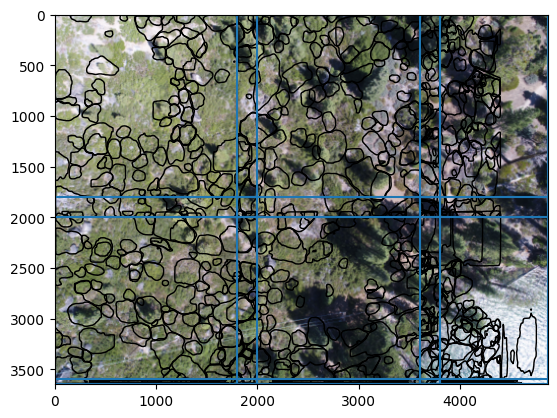

<Axes: >

In [ ]:
def show_raster(
    raster_file_path: str,
    downsample_factor: float = 10.0,
    plt_ax: Optional[plt.Axes] = None,
    CRS: Optional[pyproj.CRS] = None,
):
    """Show a raster, optionally downsampling or reprojecting it

    Args:
        raster_file_path (str): Path to the raster file
        downsample_factor (float): How much to downsample the raster before visualization
        plt_ax (Optional[plt.Axes], optional): Axes to plot on, otherwise the current ones are used
        CRS (Optional[pyproj.CRS], optional): The CRS to reproject the data to if set
    """
    # Check if the file is georeferenced
    try:
        with rasterio.open(raster_file_path) as src:
            if src.crs is None: 
                crs_available = False
            else:
                crs_available = True
    except Exception as e:
        crs_available = False  # In case of an error opening the file, treat it as not georeferenced
    
    # Handle cases where no CRS is available
    if not crs_available and CRS is not None:
        print(f"Warning: No CRS found in the raster. Proceeding without reprojection.")
        CRS = None

    # If the CRS is set, ensure the data matches it
    if CRS is not None:
        # Create a temporary file to write to
        temp_output_filename = tempfile.NamedTemporaryFile(suffix=".tif")
        # Get the name of this file
        temp_name = temp_output_filename.name
        # Reproject the raster. If the CRS was the same as requested, the original raster path will
        # be returned. Otherwise, the reprojected raster will be written to the temp file and that
        # path will be returned.
        raster_file_path = reproject_raster(
            input_file=raster_file_path, output_file=temp_name, dst_crs=CRS
        )
    
    try:
        img, _, transform = load_downsampled_raster_data(
            raster_file_path, downsample_factor=downsample_factor
        )
        # Plot the image
        rio_plot.show(source=img, transform=transform, ax=plt_ax)
    except Exception as e:
        # If the image cannot be loaded with rasterio use back to PIL for display
        img = Image.open(raster_file_path)
        if plt_ax is None:
            plt_ax = plt.gca()
        plt_ax.imshow(img)
        plt_ax.axis("off") 
        plt.show()


def plot_detections(
    data_frame: gpd.GeoDataFrame,
    bounds: gpd.GeoSeries,
    CRS: Optional[pyproj.CRS] = None,
    plt_ax: Optional[plt.axes] = None,
    plt_show: bool = True,
    visualization_column: Optional[str] = None,
    bounds_color: Optional[Union[str, np.array, pd.Series]] = None,
    detection_kwargs: dict = {},
    bounds_kwargs: dict = {},
    raster_file: Optional[PATH_TYPE] = None,
    raster_vis_downsample: float = 10.0,
) -> plt.axes:
    """Plot the detections and the bounds of the region

    Args:
        data_frame: (gpd.GeoDataFrame):
            The data representing the detections
        bounds: (gpd.GeoSeries):
            The spatial bounds of the predicted region
        CRS (Optional[pyproj.CRS], optional):
            What CRS to use. Defaults to None.
        as_pixels (bool, optional):
            Whether to display in pixel coordinates. Defaults to False.
        plt_ax (Optional[plt.axes], optional):
            A pyplot axes to plot on. If not provided, one will be created. Defaults to None.
        plt_show (bool, optional):
            Whether to plot the result or just return it. Defaults to True.
        visualization_column (Optional[str], optional):
            Which column to visualize from the detections dataframe. Defaults to None.
        bounds_color (Optional[Union[str, np.array, pd.Series]], optional):
            The color to plot the bounds. Must be accepted by the gpd.plot color argument.
            Defaults to None.
        detection_kwargs (dict, optional):
            Additional keyword arguments to pass to the .plot method for the detections.
            Defaults to {}.
        bounds_kwargs (dict, optional):
            Additional keyword arguments to pass to the .plot method for the bounds.
            Defaults to {}.
        raster_file (Optional[PATH_TYPE], optional):
            A path to a raster file to visualize the detections over if provided. Defaults to None.
        raster_vis_downsample (float, optional):
            The raster file is downsampled by this fraction before visualization to avoid
            excessive memory use or plotting time. Defaults to 10.0.

    Returns:
        plt.axes: The axes that were plotted on
    """

    # If no axes are provided, create new ones
    if plt_ax is None:
        _, plt_ax = plt.subplots()

    # Show the raster if provided
    if raster_file is not None:
        show_raster(
            raster_file_path=raster_file,
            downsample_factor=raster_vis_downsample,
            plt_ax=plt_ax,
            CRS=CRS,
        )

    # Plot the detections dataframe and the bounds on the same axes
    if "facecolor" not in detection_kwargs:
        # Plot with transperent faces unless requested
        detection_kwargs["facecolor"] = "none"

    data_frame.plot(
        ax=plt_ax, column=visualization_column, **detection_kwargs, legend=True
    )
    # Use the .boundary attribute to plot just the border. This works since it's a geoseries,
    # not a geodataframe
    bounds.boundary.plot(ax=plt_ax, color=bounds_color, **bounds_kwargs)

    # Show if requested
    if plt_show:
        plt.show()

    # Return the axes in case they need to be used later
    return plt_ax



CRS = pyproj.CRS.from_epsg(26910)
# Get the dataframe and the bounds
bounds = predictions.get_bounds(CRS=CRS, union_bounds=False)
data_frame = predictions.get_data_frame(CRS=CRS, merge=True)

plot_detections(
    data_frame=data_frame,
    bounds=bounds,
    CRS=data_frame.crs,
    raster_file=raster_file,
)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2025-01-04 00:02:29,712 - INFO - Bound have overlap, running across-region NMS
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


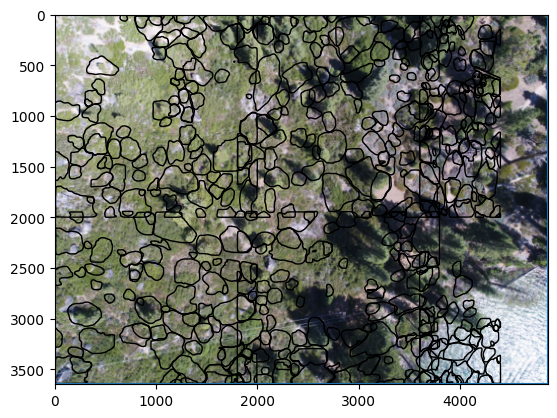

<Axes: >

In [10]:
multi_nms = multi_region_NMS(predictions)

data_frame = multi_nms.get_data_frame(CRS=CRS, as_pixels=False)
bounds = multi_nms.get_bounds(CRS, as_pixels=False)

plot_detections(
    data_frame=data_frame,
    bounds=bounds,
    CRS=data_frame.crs,
    raster_file=raster_file,
)

In [ ]:
multi_nms_ios = single_region_NMS(multi_nms, intersection_method="IOS", threshold=0.4)

data_frame = multi_nms_ios.get_data_frame(CRS=CRS, as_pixels=False)
bounds = multi_nms_ios.get_bounds(CRS, as_pixels=False)

plot_detections(
    data_frame=data_frame,
    bounds=bounds,
    CRS=data_frame.crs,
    raster_file=raster_file,
)

In [ ]:
predictions[8].plot()

In [ ]:
single_region_NMS(predictions[6], threshold=0.8).plot()

In [ ]:
predictions[3].plot()

In [12]:
elements = list(dataloader)

In [ ]:
single_region_NMS(predictions[1], threshold=0.8).plot()

In [19]:
elements[1]['image']

tensor([[[[0.0980, 0.0588, 0.0784,  ..., 0.7765, 0.7804, 0.7333],
          [0.3137, 0.1686, 0.1255,  ..., 0.7725, 0.8078, 0.8039],
          [0.5020, 0.4000, 0.2275,  ..., 0.7608, 0.7647, 0.7804],
          ...,
          [0.4353, 0.3922, 0.4392,  ..., 0.1882, 0.2510, 0.2471],
          [0.3412, 0.4471, 0.6000,  ..., 0.2118, 0.3020, 0.3255],
          [0.1843, 0.3098, 0.5255,  ..., 0.1098, 0.1961, 0.2784]],

         [[0.0745, 0.0235, 0.0353,  ..., 0.7882, 0.7922, 0.7451],
          [0.2902, 0.1451, 0.0863,  ..., 0.7882, 0.8196, 0.8157],
          [0.4902, 0.3961, 0.2078,  ..., 0.7765, 0.7804, 0.7961],
          ...,
          [0.4706, 0.4275, 0.4706,  ..., 0.2275, 0.2902, 0.2902],
          [0.3608, 0.4706, 0.6275,  ..., 0.2510, 0.3451, 0.3686],
          [0.2000, 0.3294, 0.5529,  ..., 0.1490, 0.2392, 0.3255]],

         [[0.0902, 0.0431, 0.0510,  ..., 0.6667, 0.6706, 0.6314],
          [0.2980, 0.1529, 0.0902,  ..., 0.6588, 0.6980, 0.6941],
          [0.4706, 0.3765, 0.1843,  ..., 0